# 13.2c: Verify bfloat16 Quantization

**Goal:** Determine if dead token vectors are truly quantized to bfloat16 or if they're float32 values that happen to be close.

## Method

If vectors are bfloat16-quantized:
- Each component can only take discrete values from the bfloat16 lattice
- Plotting component values should show **vertical stripes** (discrete values)
- NOT a continuous smear

We'll:
1. Extract all component values from dead token vectors
2. Plot them as a scatter to look for stripes
3. Examine spacing between adjacent unique values
4. Compare to expected bfloat16 ULP spacing

## Parameters

In [1]:
# Input
DEAD_TOKENS_PATH = "../data/tensors/13.1a_dead_tokens.safetensors"

# Figure settings
DPI = 150

RANDOM_SEED = 42

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("✓ Imports complete")

✓ Imports complete


## Load Dead Token Embeddings

In [3]:
print("Loading dead token embeddings...\n")

data = load_file(DEAD_TOKENS_PATH)

dead_embeddings_bf16 = data['dead_embeddings_bfloat16']
dead_embeddings_f32 = data['dead_embeddings_float32']

print(f"✓ Loaded dead token embeddings")
print(f"  Shape: {dead_embeddings_f32.shape}")
print(f"  bfloat16 dtype: {dead_embeddings_bf16.dtype}")
print(f"  float32 dtype: {dead_embeddings_f32.dtype}")

n_dead, n_dims = dead_embeddings_f32.shape

Loading dead token embeddings...

✓ Loaded dead token embeddings
  Shape: torch.Size([2221, 2560])
  bfloat16 dtype: torch.bfloat16
  float32 dtype: torch.float32


## Extract All Component Values

In [4]:
print("\nExtracting all component values...\n")

# Flatten to get all components
all_components_f32 = dead_embeddings_f32.flatten()
all_components_bf16 = dead_embeddings_bf16.to(torch.float32).flatten()

print(f"✓ Extracted {len(all_components_f32):,} component values")
print(f"\nValue range (float32):")
print(f"  Min: {all_components_f32.min().item():.6e}")
print(f"  Max: {all_components_f32.max().item():.6e}")
print(f"\nValue range (bfloat16):")
print(f"  Min: {all_components_bf16.min().item():.6e}")
print(f"  Max: {all_components_bf16.max().item():.6e}")


Extracting all component values...

✓ Extracted 5,685,760 component values

Value range (float32):
  Min: -8.056641e-02
  Max: 5.004883e-02

Value range (bfloat16):
  Min: -8.056641e-02
  Max: 5.004883e-02


## Find Unique Values

In [5]:
print("\nFinding unique values...\n")

# Find unique values in both representations
unique_f32 = torch.unique(all_components_f32, sorted=True)
unique_bf16 = torch.unique(all_components_bf16, sorted=True)

print(f"Number of unique values:")
print(f"  Float32: {len(unique_f32):,}")
print(f"  bfloat16: {len(unique_bf16):,}")

# If f32 has same count as bf16, they're already quantized
if len(unique_f32) == len(unique_bf16):
    print(f"\n✓ Values are already bfloat16-quantized (same unique count)")
else:
    print(f"\n→ Values may have float32 precision (different unique counts)")


Finding unique values...

Number of unique values:
  Float32: 2,962
  bfloat16: 2,962

✓ Values are already bfloat16-quantized (same unique count)


## Analyze Spacing Between Adjacent Values

In [6]:
print("\nAnalyzing spacing between adjacent unique values...\n")

# Compute gaps between consecutive unique values
gaps_f32 = unique_f32[1:] - unique_f32[:-1]
gaps_bf16 = unique_bf16[1:] - unique_bf16[:-1]

print(f"Gap statistics (float32):")
print(f"  Min gap: {gaps_f32.min().item():.6e}")
print(f"  Max gap: {gaps_f32.max().item():.6e}")
print(f"  Mean gap: {gaps_f32.mean().item():.6e}")
print(f"  Median gap: {gaps_f32.median().item():.6e}")

print(f"\nGap statistics (bfloat16):")
print(f"  Min gap: {gaps_bf16.min().item():.6e}")
print(f"  Max gap: {gaps_bf16.max().item():.6e}")
print(f"  Mean gap: {gaps_bf16.mean().item():.6e}")
print(f"  Median gap: {gaps_bf16.median().item():.6e}")

# Find most common gaps
print(f"\nMost common gaps (bfloat16):")
unique_gaps, gap_counts = torch.unique(gaps_bf16, return_counts=True)
sorted_counts, sorted_indices = torch.sort(gap_counts, descending=True)

for i in range(min(10, len(sorted_counts))):
    idx = sorted_indices[i].item()
    gap = unique_gaps[idx].item()
    count = sorted_counts[i].item()
    print(f"  {gap:12.6e}: {count:6d} occurrences")


Analyzing spacing between adjacent unique values...

Gap statistics (float32):
  Min gap: 3.725290e-09
  Max gap: 1.318359e-02
  Mean gap: 4.411186e-05
  Median gap: 1.907349e-06

Gap statistics (bfloat16):
  Min gap: 3.725290e-09
  Max gap: 1.318359e-02
  Mean gap: 4.411186e-05
  Median gap: 1.907349e-06

Most common gaps (bfloat16):
  9.536743e-07:    266 occurrences
  4.768372e-07:    260 occurrences
  1.907349e-06:    257 occurrences
  3.814697e-06:    256 occurrences
  7.629395e-06:    256 occurrences
  1.525879e-05:    256 occurrences
  3.051758e-05:    256 occurrences
  2.384186e-07:    247 occurrences
  6.103516e-05:    240 occurrences
  1.192093e-07:    150 occurrences


## Figure 1: Component Value Distribution (Stripe Test)

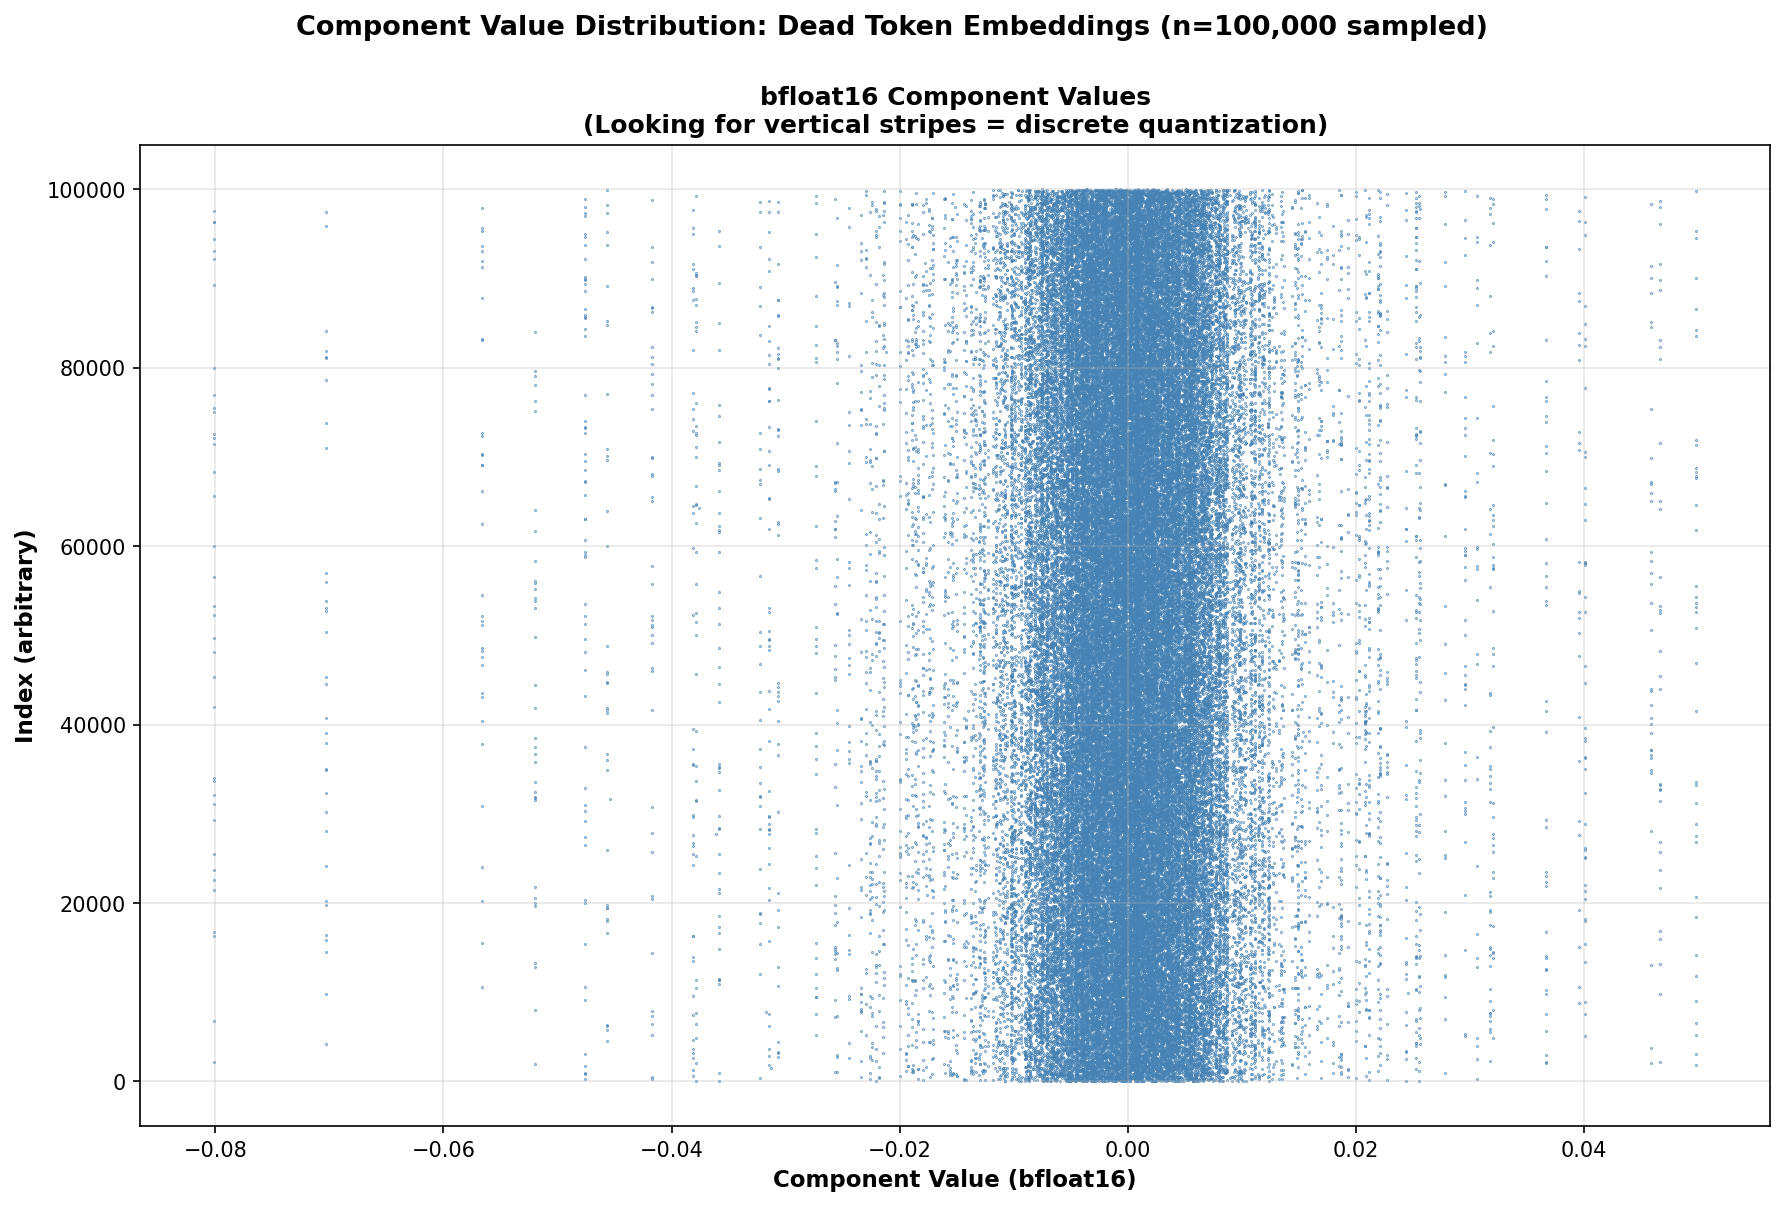


If values are quantized, you'll see vertical stripes (discrete values).
If values are continuous float32, you'll see a uniform smear.


In [76]:
# Sample for visualization (too many points otherwise)
sample_size = min(100000, len(all_components_bf16))
sample_indices = torch.randperm(len(all_components_bf16))[:sample_size]
sample_bf16 = all_components_bf16[sample_indices].cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(12, 8), dpi=DPI)

# bfloat16 values - looking for vertical stripes
ax.scatter(sample_bf16, np.arange(len(sample_bf16)), s=0.1, alpha=1, color='steelblue')
ax.set_xlabel('Component Value (bfloat16)', fontsize=11, fontweight='bold')
ax.set_ylabel('Index (arbitrary)', fontsize=11, fontweight='bold')
ax.set_title('bfloat16 Component Values\n(Looking for vertical stripes = discrete quantization)', 
             fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
# ax.set_xlim(left=-1e-3, right=1e-3)

plt.suptitle(f'Component Value Distribution: Dead Token Embeddings (n={sample_size:,} sampled)',
             fontsize=13, fontweight='bold', y=1.00)

plt.tight_layout()
plt.show()

print("\nIf values are quantized, you'll see vertical stripes (discrete values).")
print("If values are continuous float32, you'll see a uniform smear.")

## Figure 2: Gap Distribution

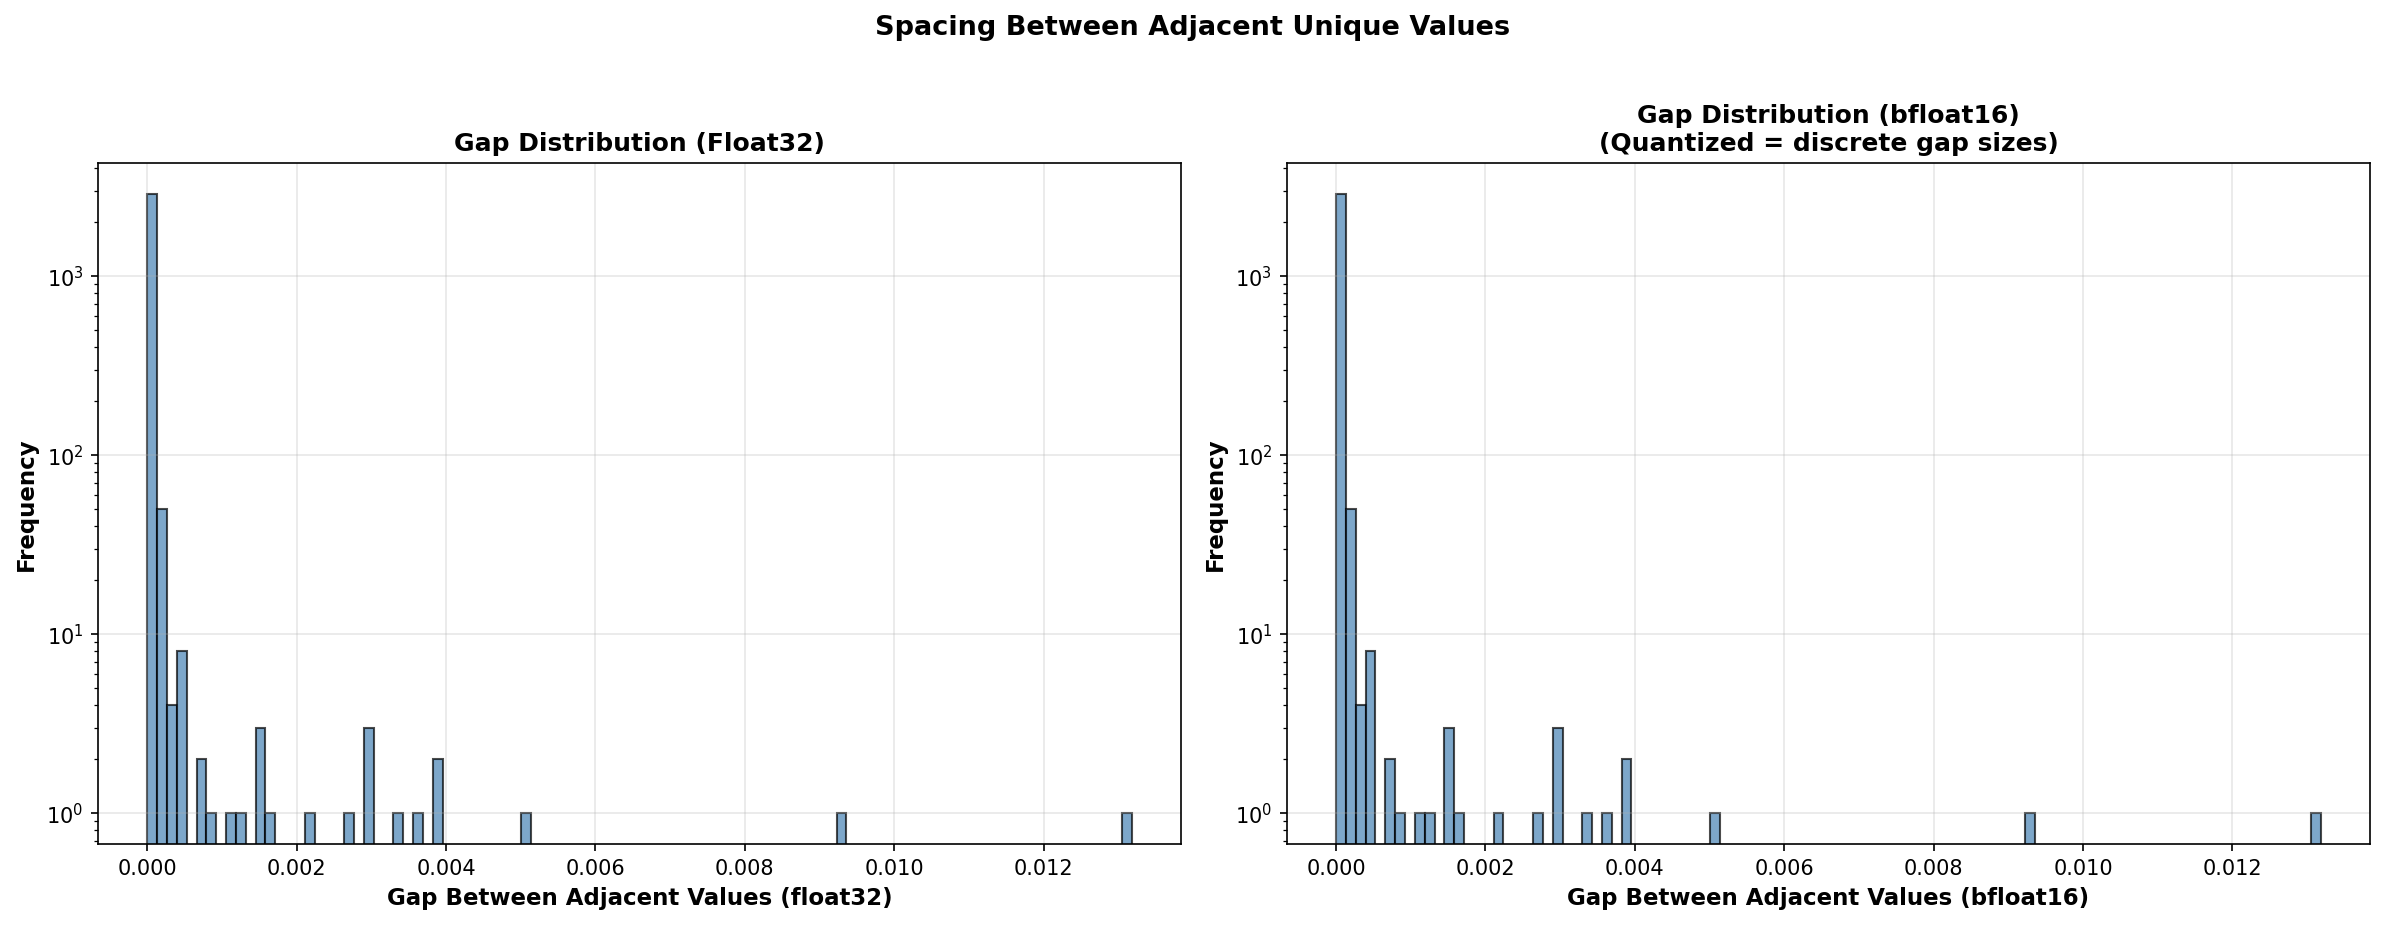


If quantized, gaps should have discrete sizes (spikes in histogram).
If continuous, gaps will have smooth distribution.


In [77]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=DPI)

# Left: Float32 gaps
ax = axes[0]
ax.hist(gaps_f32.cpu().numpy(), bins=100, color='steelblue', alpha=0.7, edgecolor='black')
ax.set_xlabel('Gap Between Adjacent Values (float32)', fontsize=11, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax.set_title('Gap Distribution (Float32)', fontsize=12, fontweight='bold')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

# Right: bfloat16 gaps
ax = axes[1]
ax.hist(gaps_bf16.cpu().numpy(), bins=100, color='steelblue', alpha=0.7, edgecolor='black')
ax.set_xlabel('Gap Between Adjacent Values (bfloat16)', fontsize=11, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax.set_title('Gap Distribution (bfloat16)\n(Quantized = discrete gap sizes)', 
             fontsize=12, fontweight='bold')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

plt.suptitle(f'Spacing Between Adjacent Unique Values',
             fontsize=13, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

print("\nIf quantized, gaps should have discrete sizes (spikes in histogram).")
print("If continuous, gaps will have smooth distribution.")

## Test: Round-trip Through bfloat16

In [78]:
print("\nTesting round-trip through bfloat16...\n")

# Convert f32 -> bf16 -> f32 and see if anything changes
roundtrip = dead_embeddings_f32.to(torch.bfloat16).to(torch.float32)

# Check if identical
is_identical = torch.equal(dead_embeddings_f32, roundtrip)

if is_identical:
    print("✓ Float32 values are IDENTICAL after round-trip through bfloat16")
    print("  → Vectors are already bfloat16-quantized")
else:
    # Count how many values changed
    changed_mask = dead_embeddings_f32 != roundtrip
    n_changed = changed_mask.sum().item()
    total = dead_embeddings_f32.numel()
    
    print(f"✗ {n_changed:,} / {total:,} values changed ({n_changed/total*100:.2f}%)")
    print(f"  → Vectors have float32 precision")
    
    # Show max difference
    diff = torch.abs(dead_embeddings_f32 - roundtrip)
    max_diff = diff.max().item()
    print(f"  → Max difference: {max_diff:.6e}")


Testing round-trip through bfloat16...

✓ Float32 values are IDENTICAL after round-trip through bfloat16
  → Vectors are already bfloat16-quantized


## Summary

In [79]:
print(f"\n{'='*80}")
print(f"QUANTIZATION VERIFICATION SUMMARY")
print(f"{'='*80}")
print(f"\nAnalyzed {n_dead:,} dead token vectors ({n_dead * n_dims:,} total components)")
print(f"\nUnique values:")
print(f"  Float32: {len(unique_f32):,}")
print(f"  bfloat16: {len(unique_bf16):,}")

if len(unique_f32) == len(unique_bf16):
    print(f"  → Same count = already quantized")

print(f"\nRound-trip test:")
if is_identical:
    print(f"  ✓ No precision loss through bfloat16")
    print(f"  → Vectors are bfloat16-quantized")
else:
    print(f"  ✗ Precision loss detected")
    print(f"  → Vectors have float32 precision")

print(f"\n{'='*80}")


QUANTIZATION VERIFICATION SUMMARY

Analyzed 2,221 dead token vectors (5,685,760 total components)

Unique values:
  Float32: 2,962
  bfloat16: 2,962
  → Same count = already quantized

Round-trip test:
  ✓ No precision loss through bfloat16
  → Vectors are bfloat16-quantized

